In [42]:
a=int(2251262633%20+1)
print(a)

14


In [43]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics as sme
from math import sqrt

from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [44]:
df = pd.read_csv('../input/monthly-beer-production/datasets_56102_107707_monthly-beer-production-in-austr.csv', header=0)
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [45]:
df.tail()

,Month,Monthly beer production
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0
475,1995-08,153.0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [47]:
df.isnull().sum().sum()

0

In [48]:
df.Month = pd.to_datetime(df.Month)
df.columns = ['date', 'production']
df.set_index('date', inplace=True)
df.head()

,production
date,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [49]:
df['log_production']=np.log(df['production'])

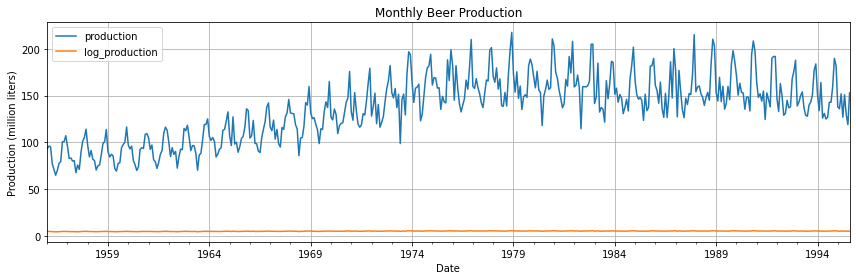

In [50]:
df.plot(title="Monthly Beer Production", figsize=(12, 4))
plt.ylabel("Production (million liters)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
X = df.drop(['production'], axis=1)
start_date = '1957-01-01'
split_date = '1986-12-01'
train = X.loc[(X.index >= start_date) & (X.index <= split_date)].copy()
test = X.loc[X.index > split_date].copy()

In [52]:
from statsmodels.tsa.stattools import adfuller

stat_result = adfuller(df['log_production'].dropna())
print('ADF Statistic:', stat_result[0])
print('p-value:', stat_result[1])
print('Critical Values:')
for key, value in stat_result[4].items():
    print(f'\t{key}: {value:.3f}')


ADF Statistic: -2.8007688010978518
p-value: 0.058164034194259286
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [53]:
df['log_diff'] = df['log_production'].diff()


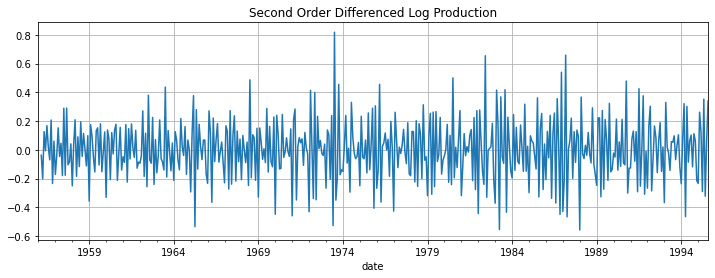

ADF Statistic: -14.580776450981418
p-value: 4.47227474660261e-27
Critical Values:
  1%: -3.445
  5%: -2.868
  10%: -2.570


In [54]:

df['log_diff2'] = df['log_diff'].diff()


df['log_diff2'].plot(title='Second Order Differenced Log Production', figsize=(12,4))
plt.grid(True)
plt.show()

from statsmodels.tsa.stattools import adfuller
result = adfuller(df['log_diff2'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value:.3f}")


In [55]:
from statsmodels.tsa.ar_model import AutoReg

df_log_diff = df['log_diff2'].dropna()
model = AutoReg(df_log_diff, lags=2, old_names=False).fit()
print(model.summary())


                            AutoReg Model Results                             
Dep. Variable:              log_diff2   No. Observations:                  474
Model:                     AutoReg(2)   Log Likelihood                 208.074
Method:               Conditional MLE   S.D. of innovations              0.156
Date:                Tue, 03 Jun 2025   AIC                             -3.703
Time:                        08:10:17   BIC                             -3.667
Sample:                    05-01-1956   HQIC                            -3.689
                         - 08-01-1995                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0007      0.007      0.092      0.926      -0.013       0.015
log_diff2.L1    -0.8268      0.041    -20.230      0.000      -0.907      -0.747
log_diff2.L2    -0.4667      0.041    -11.41

In [56]:

print("\nConfidence intervals for coefficients:")
print(model.conf_int())

print("\nP-values for coefficients:")
print(model.pvalues)



Confidence intervals for coefficients:
                     0         1
const        -0.013385  0.014709
log_diff2.L1 -0.906904 -0.746693
log_diff2.L2 -0.546761 -0.386542

P-values for coefficients:
const           9.264403e-01
log_diff2.L1    5.377091e-91
log_diff2.L2    3.435270e-30
dtype: float64
